# Interpolation Benchmarks in JAX for Sub-pixel DIC: im_jax vs map_coordinates(order=3)


## Overview
This notebook refactors the benchmark to focus on two methods:
- `im_jax.flat_nd_cubic_interpolate` (Keys cubic, a=-0.5)
- `jax.scipy.ndimage.map_coordinates` with `order=3`

We report:
- Validation errors (im_jax vs map_coordinates order=3)
- CPU/GPU runtime vs image size (7 log-spaced sizes, <= 25 MPx)
- Runtime vs number of interpolation points for a 15 MPx image


## Environment & Reproducibility


In [1]:
# Environment details and single RNG seed
import platform
import time

import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 0

print('jax:', jax.__version__)
print('jaxlib:', jax.lib.__version__)
print('platform:', platform.platform())
print('devices:', jax.devices())
print('default dtype:', jnp.ones((), dtype=jnp.float32).dtype)
print('x64 enabled:', jax.config.read('jax_enable_x64'))


jax: 0.8.1
jaxlib: 0.8.1
platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35
devices: [CudaDevice(id=0)]
default dtype: float32
x64 enabled: False


W1224 11:20:42.911448   97699 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1224 11:20:42.913722   97593 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Methods Under Test
Locations use the DIC convention: a `2 x N` array with `x=row` and `y=col`.


In [2]:
# Optional SciPy fallback for order=3 reference on CPU
try:
    from scipy.ndimage import map_coordinates as scipy_map_coordinates
    HAS_SCIPY = True
except Exception as exc:
    HAS_SCIPY = False
    scipy_map_coordinates = None
    print('Warning: SciPy not available, order=3 reference may be skipped. Error:', exc)

import im_jax

# Detect whether JAX map_coordinates supports order=3
SUPPORTS_JAX_ORDER3 = True
try:
    _test_img = jnp.zeros((2, 2), dtype=jnp.float32)
    _test_loc = jnp.zeros((2, 1), dtype=jnp.float32)
    map_coordinates(_test_img, _test_loc, order=3)
except Exception:
    SUPPORTS_JAX_ORDER3 = False


def map_coordinates_order3(image, locations, *, mode='reflect', cval=0.0, backend='jax'):
    if backend == 'jax':
        if not SUPPORTS_JAX_ORDER3:
            raise NotImplementedError('jax.scipy.ndimage.map_coordinates order=3 not supported')
        return map_coordinates(image, locations, order=3, mode=mode, cval=cval)
    if backend == 'scipy':
        if not HAS_SCIPY:
            raise RuntimeError('SciPy not available for order=3')
        out = scipy_map_coordinates(
            np.asarray(image),
            np.asarray(locations),
            order=3,
            mode=mode,
            cval=cval,
        )
        return jnp.asarray(out)
    raise ValueError(f'Unknown backend: {backend}')


def im_jax_cubic(image, locations, *, mode='reflect', cval=0.0):
    return im_jax.flat_nd_cubic_interpolate(
        image,
        locations,
        mode=mode,
        cval=cval,
        kernel='keys',
        a=-0.5,
    )


## Test Data Generation


In [3]:
import jax.lax as lax


def gaussian_kernel1d(sigma, radius=None, dtype=jnp.float32):
    if sigma <= 0:
        return jnp.array([1.0], dtype=dtype)
    if radius is None:
        radius = int(3 * sigma + 0.5)
    x = jnp.arange(-radius, radius + 1, dtype=dtype)
    kernel = jnp.exp(-(x ** 2) / (2 * sigma ** 2))
    kernel = kernel / jnp.sum(kernel)
    return kernel


def blur_separable(image_hw, kernel_1d):
    # Use NCHW layout for conv; apply separable blur.
    k = kernel_1d
    radius = int((k.shape[0] - 1) // 2)
    img = image_hw[None, None, :, :]

    k_row = k.reshape(1, 1, -1, 1)
    k_col = k.reshape(1, 1, 1, -1)

    img = lax.conv_general_dilated(
        img,
        k_row,
        window_strides=(1, 1),
        padding=((radius, radius), (0, 0)),
        dimension_numbers=('NCHW', 'OIHW', 'NCHW'),
    )
    img = lax.conv_general_dilated(
        img,
        k_col,
        window_strides=(1, 1),
        padding=((0, 0), (radius, radius)),
        dimension_numbers=('NCHW', 'OIHW', 'NCHW'),
    )
    return img[0, 0]


def make_speckle_image(H, W, *, seed, smooth_sigma=0.0, dtype=jnp.float32):
    key = jax.random.PRNGKey(seed)
    image = jax.random.normal(key, (H, W), dtype=dtype)
    if smooth_sigma and smooth_sigma > 0:
        kernel = gaussian_kernel1d(smooth_sigma, dtype=dtype)
        image = blur_separable(image, kernel)
    return image


def make_locations(H, W, N, *, seed, margin=0.0, dtype=jnp.float32):
    key = jax.random.PRNGKey(seed)
    low_x = -margin
    high_x = (H - 1) + margin
    low_y = -margin
    high_y = (W - 1) + margin
    key, sub = jax.random.split(key)
    x = jax.random.uniform(sub, (N,), minval=low_x, maxval=high_x, dtype=dtype)
    key, sub = jax.random.split(key)
    y = jax.random.uniform(sub, (N,), minval=low_y, maxval=high_y, dtype=dtype)
    return jnp.stack([x, y], axis=0)


## Validation: im_jax vs map_coordinates(order=3)


/tmp/ipykernel_97593/643380543.py:43: UserWarning: Explicitly requested dtype float64 is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  image = jax.random.normal(key, (H, W), dtype=dtype)
/opt/conda/envs/science/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5947: UserWarning: Explicitly requested dtype float64 requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return _arange(start, stop=stop, step=step, dtype=dtype,
/tmp/ipykernel_97593/643380543.py:57: UserWarning: Explicitly requested dtype float64 is not available, and will be truncated to dtype float32. To enable more dtypes, set the j

   method                       reference     H     W       N  max_abs_error  \
0  im_jax  scipy.map_coordinates(order=3)  1024  1024  200000       0.405173   

   mean_abs_error  rms_error  
0        0.004067    0.00991  


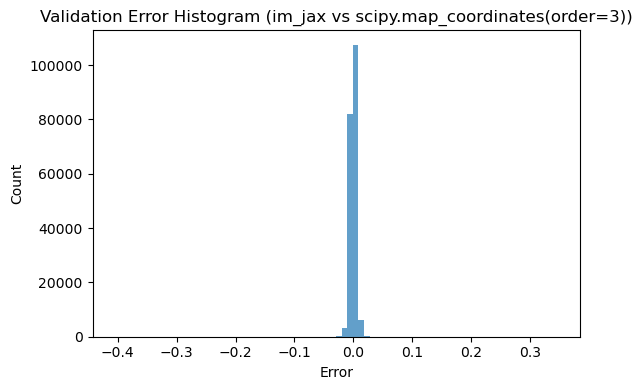

In [4]:
def compute_errors(pred, ref):
    err = pred - ref
    max_abs = jnp.max(jnp.abs(err))
    mean_abs = jnp.mean(jnp.abs(err))
    rms = jnp.sqrt(jnp.mean(err ** 2))
    return {
        'max_abs_error': float(max_abs),
        'mean_abs_error': float(mean_abs),
        'rms_error': float(rms),
    }


def validation_run():
    H, W = 1024, 1024
    N = 200_000
    dtype = jnp.float64
    image = make_speckle_image(H, W, seed=SEED, smooth_sigma=1.2, dtype=dtype)
    locations = make_locations(H, W, N, seed=SEED + 1, margin=2.0, dtype=dtype)

    if SUPPORTS_JAX_ORDER3:
        ref = map_coordinates_order3(image, locations, mode='reflect', backend='jax')
        ref_label = 'jax.map_coordinates(order=3)'
    elif HAS_SCIPY:
        print('Warning: JAX order=3 not supported, using SciPy as reference.')
        ref = map_coordinates_order3(image, locations, mode='reflect', backend='scipy')
        ref_label = 'scipy.map_coordinates(order=3)'
    else:
        raise RuntimeError('No order=3 reference available (JAX or SciPy).')

    pred = im_jax_cubic(image, locations, mode='reflect')
    metrics = compute_errors(pred, ref)

    df = pd.DataFrame([
        {
            'method': 'im_jax',
            'reference': ref_label,
            'H': H,
            'W': W,
            'N': N,
            **metrics,
        }
    ])

    # Histogram of errors
    err = np.asarray(pred - ref)
    plt.figure(figsize=(6, 4))
    plt.hist(err, bins=80, alpha=0.7)
    plt.title(f'Validation Error Histogram (im_jax vs {ref_label})')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.tight_layout()

    return df


df_validation = validation_run()
print(df_validation)


## Performance: CPU/GPU vs Image Size (7 log-spaced sizes)


W1224 11:21:02.145396   97714 hlo_rematerialization.cc:3204] Can't reduce memory use below 5.99GiB (6434525710 bytes) by rematerialization; only reduced to 6.82GiB (7324946847 bytes), down from 6.82GiB (7324946847 bytes) originally
W1224 11:21:14.683350   97593 bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.73GiB (rounded to 7224627200)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W1224 11:21:14.685061   97593 bfc_allocator.cc:512] *********___________________________________________________________________________________________
W1224 11:21:14.698367   97707 hlo_rematerialization.cc:3204] Can't reduce memory use below 5.99GiB (6434525710 bytes) by rematerialization; only reduced to 6.82GiB (7324946847 bytes), down from 6.82GiB (7324946847 bytes) originally
W1224 11:21:27.032

   device            method                        dtype     H     W  \
0     cpu            im_jax  <class 'jax.numpy.float32'>   512   512   
1     cpu  map_order3_scipy  <class 'jax.numpy.float32'>   512   512   
2     cpu            im_jax  <class 'jax.numpy.float32'>   752   752   
3     cpu  map_order3_scipy  <class 'jax.numpy.float32'>   752   752   
4     cpu            im_jax  <class 'jax.numpy.float32'>  1104  1104   
5     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  1104  1104   
6     cpu            im_jax  <class 'jax.numpy.float32'>  1600  1600   
7     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  1600  1600   
8     cpu            im_jax  <class 'jax.numpy.float32'>  2352  2352   
9     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  2352  2352   
10    cpu            im_jax  <class 'jax.numpy.float32'>  3424  3424   
11    cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3424  3424   
12    cpu            im_jax  <class 'jax.numpy.float32'>  5008  

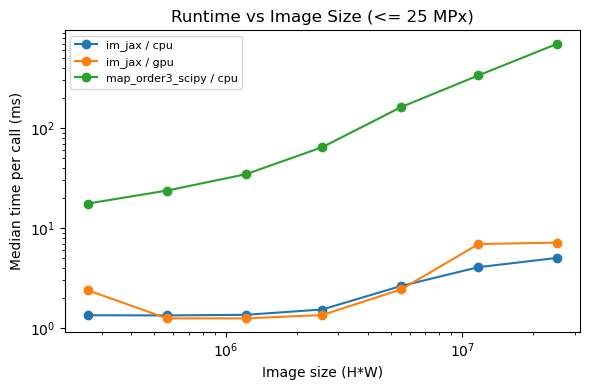

In [5]:
def bench(fn, image, locations, static_kwargs, repeats=10):
    # SciPy backend cannot be jitted; run eager timing instead.
    if static_kwargs.get('backend') == 'scipy':
        t0 = time.perf_counter()
        out = fn(image, locations, **static_kwargs)
        if hasattr(out, 'block_until_ready'):
            out.block_until_ready()
        first_s = time.perf_counter() - t0

        times = []
        for _ in range(repeats):
            t1 = time.perf_counter()
            out = fn(image, locations, **static_kwargs)
            if hasattr(out, 'block_until_ready'):
                out.block_until_ready()
            times.append(time.perf_counter() - t1)

        median_s = float(np.median(times))
        min_s = float(np.min(times))
        throughput = locations.shape[1] / median_s if median_s > 0 else float('inf')

        return {
            'compile_ms': first_s * 1e3,
            'median_ms': median_s * 1e3,
            'min_ms': min_s * 1e3,
            'samples_per_s': throughput,
        }

    static_argnames = tuple(static_kwargs.keys())
    jitted = jax.jit(fn, static_argnames=static_argnames)

    t0 = time.perf_counter()
    out = jitted(image, locations, **static_kwargs)
    out.block_until_ready()
    compile_s = time.perf_counter() - t0

    times = []
    for _ in range(repeats):
        t1 = time.perf_counter()
        out = jitted(image, locations, **static_kwargs)
        out.block_until_ready()
        times.append(time.perf_counter() - t1)

    median_s = float(np.median(times))
    min_s = float(np.min(times))
    throughput = locations.shape[1] / median_s if median_s > 0 else float('inf')

    return {
        'compile_ms': compile_s * 1e3,
        'median_ms': median_s * 1e3,
        'min_ms': min_s * 1e3,
        'samples_per_s': throughput,
    }


def log_spaced_sizes(max_pixels=25_000_000, count=7):
    min_pixels = 512 * 512
    targets = np.logspace(np.log10(min_pixels), np.log10(max_pixels), count)
    sizes = []
    for p in targets:
        side = int(round(float(p) ** 0.5))
        side = max(16, (side + 15) // 16 * 16)
        sizes.append((side, side))
    return sorted(set(sizes))


def run_perf_vs_size(device, device_label, n_points=200_000, dtype=jnp.float32):
    sizes = log_spaced_sizes(max_pixels=25_000_000, count=7)
    rows = []
    for H, W in sizes:
        image = make_speckle_image(H, W, seed=SEED + 100, smooth_sigma=1.0, dtype=dtype)
        locations = make_locations(H, W, n_points, seed=SEED + 101, margin=2.0, dtype=dtype)
        image = jax.device_put(image, device)
        locations = jax.device_put(locations, device)

        methods = [
            ('im_jax', im_jax_cubic, {'mode': 'reflect', 'cval': 0.0}),
        ]
        if SUPPORTS_JAX_ORDER3:
            methods.append(('map_order3', map_coordinates_order3, {'mode': 'reflect', 'cval': 0.0, 'backend': 'jax'}))
        elif device_label == 'cpu' and HAS_SCIPY:
            methods.append(('map_order3_scipy', map_coordinates_order3, {'mode': 'reflect', 'cval': 0.0, 'backend': 'scipy'}))

        for name, fn, kwargs in methods:
            try:
                metrics = bench(fn, image, locations, kwargs, repeats=10)
            except RuntimeError as exc:
                print(f'Skipping {name} on {device_label} {H}x{W}:', exc)
                continue

            rows.append({
                'device': device_label,
                'method': name,
                'dtype': str(dtype),
                'H': H,
                'W': W,
                'pixels': H * W,
                'N': n_points,
                'compile_ms': metrics['compile_ms'],
                'median_ms': metrics['median_ms'],
                'min_ms': metrics['min_ms'],
                'samples_per_s': metrics['samples_per_s'],
            })

    return pd.DataFrame(rows)


cpu_device = jax.devices('cpu')[0]
df_size_cpu = run_perf_vs_size(cpu_device, 'cpu', n_points=200_000, dtype=jnp.float32)
print(df_size_cpu)

try:
    gpu_devices = jax.devices('gpu')
except Exception:
    gpu_devices = []

if gpu_devices:
    df_size_gpu = run_perf_vs_size(gpu_devices[0], 'gpu', n_points=200_000, dtype=jnp.float32)
    print(df_size_gpu)
else:
    df_size_gpu = pd.DataFrame([])
    print('No GPU devices detected; GPU benchmarks skipped.')

# Plot performance vs image size
size_df = pd.concat([df_size_cpu, df_size_gpu], ignore_index=True)
if not size_df.empty:
    plt.figure(figsize=(6, 4))
    for (method, device), sub in size_df.groupby(['method', 'device']):
        sub = sub.sort_values('pixels')
        label = f'{method} / {device}'
        plt.plot(sub['pixels'], sub['median_ms'], marker='o', label=label)
    plt.xlabel('Image size (H*W)')
    plt.ylabel('Median time per call (ms)')
    plt.title('Runtime vs Image Size (<= 25 MPx)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()


## Performance: CPU/GPU vs Number of Points (15 MPx image)


   device            method                        dtype     H     W  \
0     cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
1     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
2     cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
3     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
4     cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
5     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
6     cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
7     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
8     cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
9     cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
10    cpu            im_jax  <class 'jax.numpy.float32'>  3888  3888   
11    cpu  map_order3_scipy  <class 'jax.numpy.float32'>  3888  3888   
12    cpu            im_jax  <class 'jax.numpy.float32'>  3888  

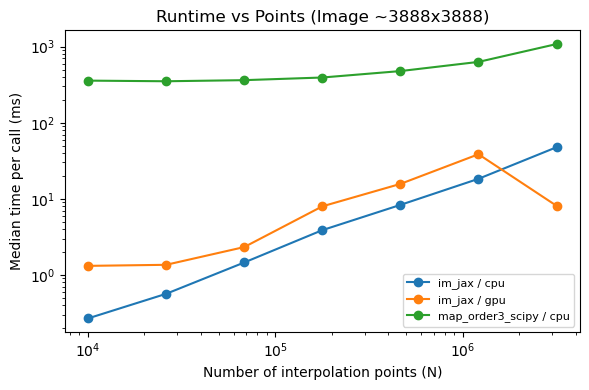

In [6]:
def run_perf_vs_points(device, device_label, H, W, point_counts, dtype=jnp.float32):
    rows = []
    image = make_speckle_image(H, W, seed=SEED + 200, smooth_sigma=1.0, dtype=dtype)
    image = jax.device_put(image, device)

    for N in point_counts:
        locations = make_locations(H, W, int(N), seed=SEED + 201, margin=2.0, dtype=dtype)
        locations = jax.device_put(locations, device)

        methods = [
            ('im_jax', im_jax_cubic, {'mode': 'reflect', 'cval': 0.0}),
        ]
        if SUPPORTS_JAX_ORDER3:
            methods.append(('map_order3', map_coordinates_order3, {'mode': 'reflect', 'cval': 0.0, 'backend': 'jax'}))
        elif device_label == 'cpu' and HAS_SCIPY:
            methods.append(('map_order3_scipy', map_coordinates_order3, {'mode': 'reflect', 'cval': 0.0, 'backend': 'scipy'}))

        for name, fn, kwargs in methods:
            try:
                metrics = bench(fn, image, locations, kwargs, repeats=10)
            except RuntimeError as exc:
                print(f'Skipping {name} on {device_label} N={N}:', exc)
                continue

            rows.append({
                'device': device_label,
                'method': name,
                'dtype': str(dtype),
                'H': H,
                'W': W,
                'pixels': H * W,
                'N': int(N),
                'compile_ms': metrics['compile_ms'],
                'median_ms': metrics['median_ms'],
                'min_ms': metrics['min_ms'],
                'samples_per_s': metrics['samples_per_s'],
            })

    return pd.DataFrame(rows)


# 15 MPx image (rounded to a multiple of 16)
side = int(round((15_000_000) ** 0.5))
side = max(16, (side + 15) // 16 * 16)
H_15, W_15 = side, side

point_counts = np.logspace(4, 6.5, 7)  # ~10k to ~3.1M

cpu_device = jax.devices('cpu')[0]
df_points_cpu = run_perf_vs_points(cpu_device, 'cpu', H_15, W_15, point_counts, dtype=jnp.float32)
print(df_points_cpu)

if gpu_devices:
    df_points_gpu = run_perf_vs_points(gpu_devices[0], 'gpu', H_15, W_15, point_counts, dtype=jnp.float32)
    print(df_points_gpu)
else:
    df_points_gpu = pd.DataFrame([])

# Plot runtime vs number of points
points_df = pd.concat([df_points_cpu, df_points_gpu], ignore_index=True)
if not points_df.empty:
    plt.figure(figsize=(6, 4))
    for (method, device), sub in points_df.groupby(['method', 'device']):
        sub = sub.sort_values('N')
        label = f'{method} / {device}'
        plt.plot(sub['N'], sub['median_ms'], marker='o', label=label)
    plt.xlabel('Number of interpolation points (N)')
    plt.ylabel('Median time per call (ms)')
    plt.title(f'Runtime vs Points (Image ~{H_15}x{W_15})')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()
